# Detekcja naczyń dna oka z użyciem technik przetwarzania obrazu

### Wprowadzenie

Najpierw dokonajmy odpowiednich importów. Biblioteką wiodącą w przetwarzaniu jest openCV, choć sam rdzeń czyli funkcja wykrywająca naczynia (`frangi`) znajduje się w bibliotece `skimage`. Dodatkowo korzystamy z `numpy`, aby móc modyfikować obrazy (macierze). W celach oceny jakości klasyfikacji korzystami z `sklearn` oraz `imblearn`. W celach wizualizacji wyników posłużymy się `matplotlib`. Biblioteka `os` będzie pomocna przy wczytywaniu obrazów. 

In [83]:
import cv2 as cv

import os

from skimage.filters import frangi

import numpy as np

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.metrics import sensitivity_specificity_support

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,8)

In [84]:
def plt_image(image: np.ndarray, title: str = '', cmap: str = 'gray'):
    plt.title(title)
    plt.axis('off')
    plt.imshow(image, cmap=cmap)

def normalize(image: np.ndarray, factor: float) -> np.ndarray:
    image = image * (factor / image.max())
    return image

W kolejnych krokach przedstawimy zastosowane podejście na przykładzie wybranego obrazu. Następnie sprawdzimy jakość klasyfikacji na podstawie 5 losowo wybranych obrazów. Wczytajmy zatem przykładowy obraz.

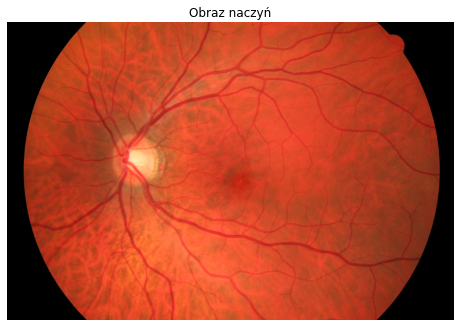

In [85]:
color_image = cv.imread('examples/02_h.jpg')

plt_image(cv.cvtColor(color_image, cv.COLOR_BGR2RGB), 'Obraz naczyń', None)

W celu dalszego przetwarzania obrazu naczyń dna oka konieczne jest usunięcie kolorów. Najbardziej przydatny będzie kanał z kolorem zielonym, stąd tylko ten kolor pozostawiamy na obrazie.

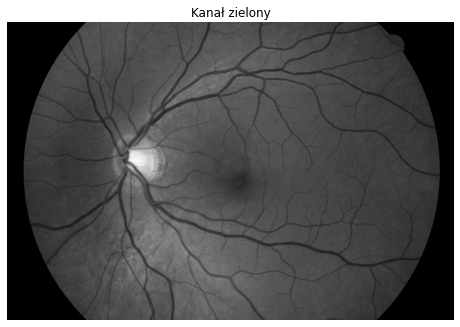

In [86]:
gray_image = color_image[:,:,1]

plt_image(gray_image, 'Kanał zielony')

Naczynia na powyższym obrazie są dość dobrze widoczne. Jednak można jeszcze bardziej polepszyć kontrast używając metody wyrównywania histogramu. Można użyć do tego np. funkcji `equalizeHist()` jednak dużo lepszy rezultat daje adaptacyjna metoda `CLAHE`.

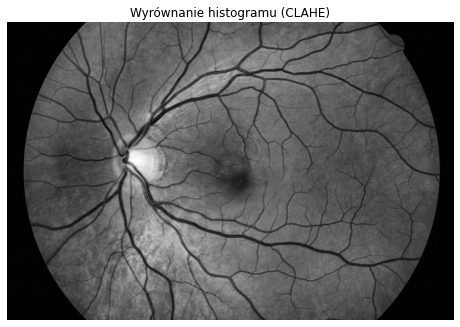

In [87]:
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized = clahe.apply(gray_image)

plt_image(equalized, 'Wyrównanie histogramu (CLAHE)')

Kolejnym istotnym krokiem jest usunięcie szumu z obrazu. Bardzo dobrze sprawdzi się jedna z metod `non-local means`, a dokładniej funkcja `fastNlMeansDenoising()`. Niestety dobór parametrów tej funkcji to swoisty kompromis między zbyt dużą ilością szumu (nie-naczyń) oraz zbyt małą liczbą cienkich naczyń.  

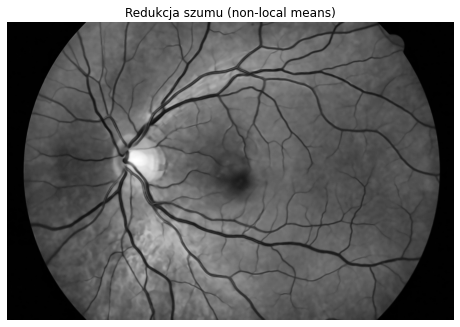

In [88]:
denoised = cv.fastNlMeansDenoising(equalized, None, 15, 25, 25)

plt_image(denoised, 'Redukcja szumu (non-local means)')

Na tym etapie można przejść do wykrywania naczyń. W tym celu skorzystamy z funkcji `frangi()` stworzonej właśnie w tym celu. Przy okazji znormalizujemy obraz do wartości 0-255.

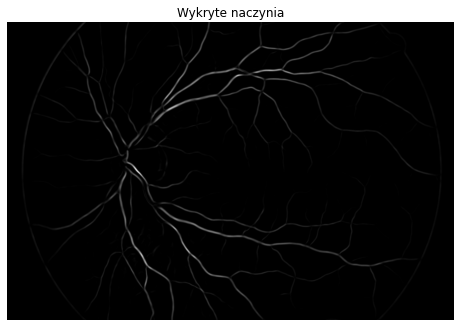

In [89]:
vessels = frangi(denoised)
vessels = normalize(vessels, 255).astype(np.uint8)

plt_image(vessels, 'Wykryte naczynia')

Teraz można dokonać bardzo prostego progowania - wszystko co jest inne niż czerń uznajmy za biel.

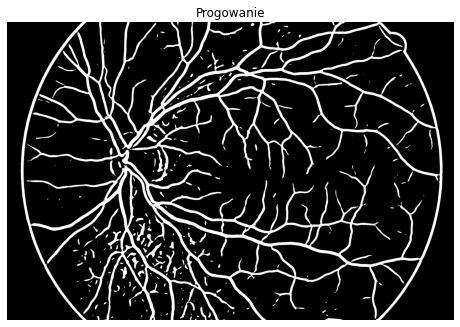

In [90]:
_, thresh = cv.threshold(vessels, 0, 255, cv.THRESH_BINARY)

plt_image(thresh, "Progowanie")

Następny krok obejmuje usunięcie małych obiektów, które pozostały na obrazie. Dokonać można tego z użyciem `connectedComponentsWithStats`. 

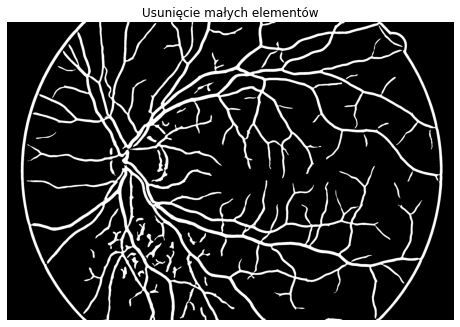

In [91]:
def remove_small_elements(image: np.ndarray, min_size: int) -> np.ndarray:
    components, output, stats, _ = cv.connectedComponentsWithStats(
        image, connectivity=8)

    sizes = stats[1:, -1]
    components -= 1

    result = np.zeros((output.shape))

    for i in range(0, components):
        if sizes[i] >= min_size:
            result[output == i + 1] = 255

    return result

small_removed = remove_small_elements(thresh, 800).astype(np.uint8)

plt_image(small_removed, 'Usunięcie małych elementów')

Na koniec pozostało jedynie usunięcie granicy oka. W tym celu cofniemy się do kolorowego zdjęcia i na tej podstawie przygotujemy maskę.

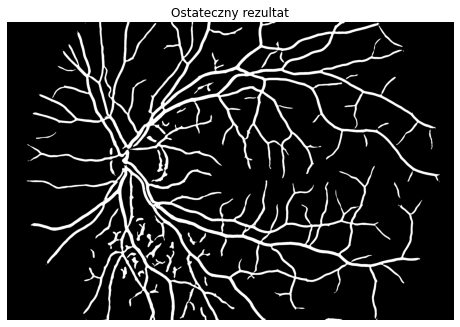

In [92]:
def remove_border(color_img: np.ndarray, image: np.ndarray) -> np.ndarray:
    hsv = cv.cvtColor(color_img, cv.COLOR_BGR2HSV)
    lower = np.array([0, 0, 80])
    upper = np.array([255, 255, 255])
    mask = cv.inRange(hsv, lower, upper)
    
    return cv.bitwise_and(image, mask)

end_result = remove_border(color_image, small_removed)
plt_image(end_result, 'Ostateczny rezultat')

### Gotowa funkcja
Poniżej przedstawiono gotową funkcję realizującą opisane przetwarzanie. Funkcja korzysta z implementacji `normalize()`, `remove_small_elements()`, `remove_border()`.

In [93]:
def process_input(path: str) -> np.ndarray:
    color_image = cv.imread(path)
    if color_image is None:
        raise FileNotFoundError(f'"{path}" not found')

    gray_image = color_image[:,:,1]

    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(gray_image)

    denoised = cv.fastNlMeansDenoising(equalized, None, 15, 25, 25)
    vessels = normalize(frangi(denoised), 255).astype(np.uint8)
    _, thresh = cv.threshold(vessels, 0, 255, cv.THRESH_BINARY)
    small_removed = remove_small_elements(thresh, 800).astype(np.uint8)
    end_result = remove_border(color_image, small_removed)
    
    return end_result
    

### Analiza jakości podejścia
W celu porównania uzyskanych wyników z maską ekspercką stwórzmy funkcję wyświetlającą wybrane miary klasyfikacji.

In [94]:
# Helper function
def is_binary(image: np.ndarray) -> bool:
    return ((image == 0) | (image == 255)).all()

def compare(image: np.ndarray, truth: np.ndarray) -> dict:
    if not is_binary(image):
        raise Exception('Image is not binary (0 or 255)')
    
    if not is_binary(truth):
        raise Exception('Ground truth is not binary (0 or 255')

    image = image.flatten()
    truth = truth.flatten()

    report = classification_report(truth, image, output_dict=True)

    accuracy = round(accuracy_score(truth, image), 2)
    sensivity = round(report['255']['recall'], 2)
    specifity = round(report['0']['recall'], 2)

    weighted_result = sensitivity_specificity_support(
        truth, image, average='weighted')

    weight_sensivity = round(weighted_result[0], 2)
    weight_specifity = round(weighted_result[1], 2)
    matrix = confusion_matrix(truth, image)

    return {
        'accuracy': accuracy,
        'sensivity': sensivity,
        'specifity': specifity,
        'weight_sensivity': weight_sensivity,
        'weight_specifity': weight_specifity,
        'matrix': matrix.flatten()
    }

Dodatkowo warto zwizualizować uzyskane naczynia na masce eksperckiej. Dokonamy tego poprzez naniesienie na maskę ekspercką zielonych pikseli, uznanych za naczynia.

In [95]:
def visualise(image: np.ndarray, truth: np.ndarray) -> np.ndarray:
    predicted_vessels = (image == 255)
    true_vessels = (truth  == 255)

    predicted_correct = (predicted_vessels & true_vessels)

    green_predicted = np.zeros((*truth.shape, 3), dtype=np.uint8)
    green_predicted[true_vessels, :] = 255

    green_predicted[predicted_correct] = [0, 255, 0]

    return green_predicted

W końcu można dokonać analizy wybranych obrazów.

01_dr.JPG: {'accuracy': 0.93, 'sensivity': 0.87, 'specifity': 0.93, 'weight_sensivity': 0.93, 'weight_specifity': 0.87, 'matrix': array([7228123,  540939,   56044,  360238])}
01_g.jpg: {'accuracy': 0.95, 'sensivity': 0.79, 'specifity': 0.96, 'weight_sensivity': 0.95, 'weight_specifity': 0.8, 'matrix': array([7346813,  290899,  113636,  433996])}
01_h.jpg: {'accuracy': 0.95, 'sensivity': 0.73, 'specifity': 0.98, 'weight_sensivity': 0.95, 'weight_specifity': 0.76, 'matrix': array([7176409,  175047,  224252,  609636])}
02_dr.JPG: {'accuracy': 0.93, 'sensivity': 0.81, 'specifity': 0.94, 'weight_sensivity': 0.93, 'weight_specifity': 0.82, 'matrix': array([7220643,  442823,   97073,  424805])}
02_g.jpg: {'accuracy': 0.94, 'sensivity': 0.82, 'specifity': 0.95, 'weight_sensivity': 0.94, 'weight_specifity': 0.83, 'matrix': array([7189593,  386029,  106960,  502762])}
02_h.jpg: {'accuracy': 0.95, 'sensivity': 0.84, 'specifity': 0.96, 'weight_sensivity': 0.95, 'weight_specifity': 0.85, 'matrix': 

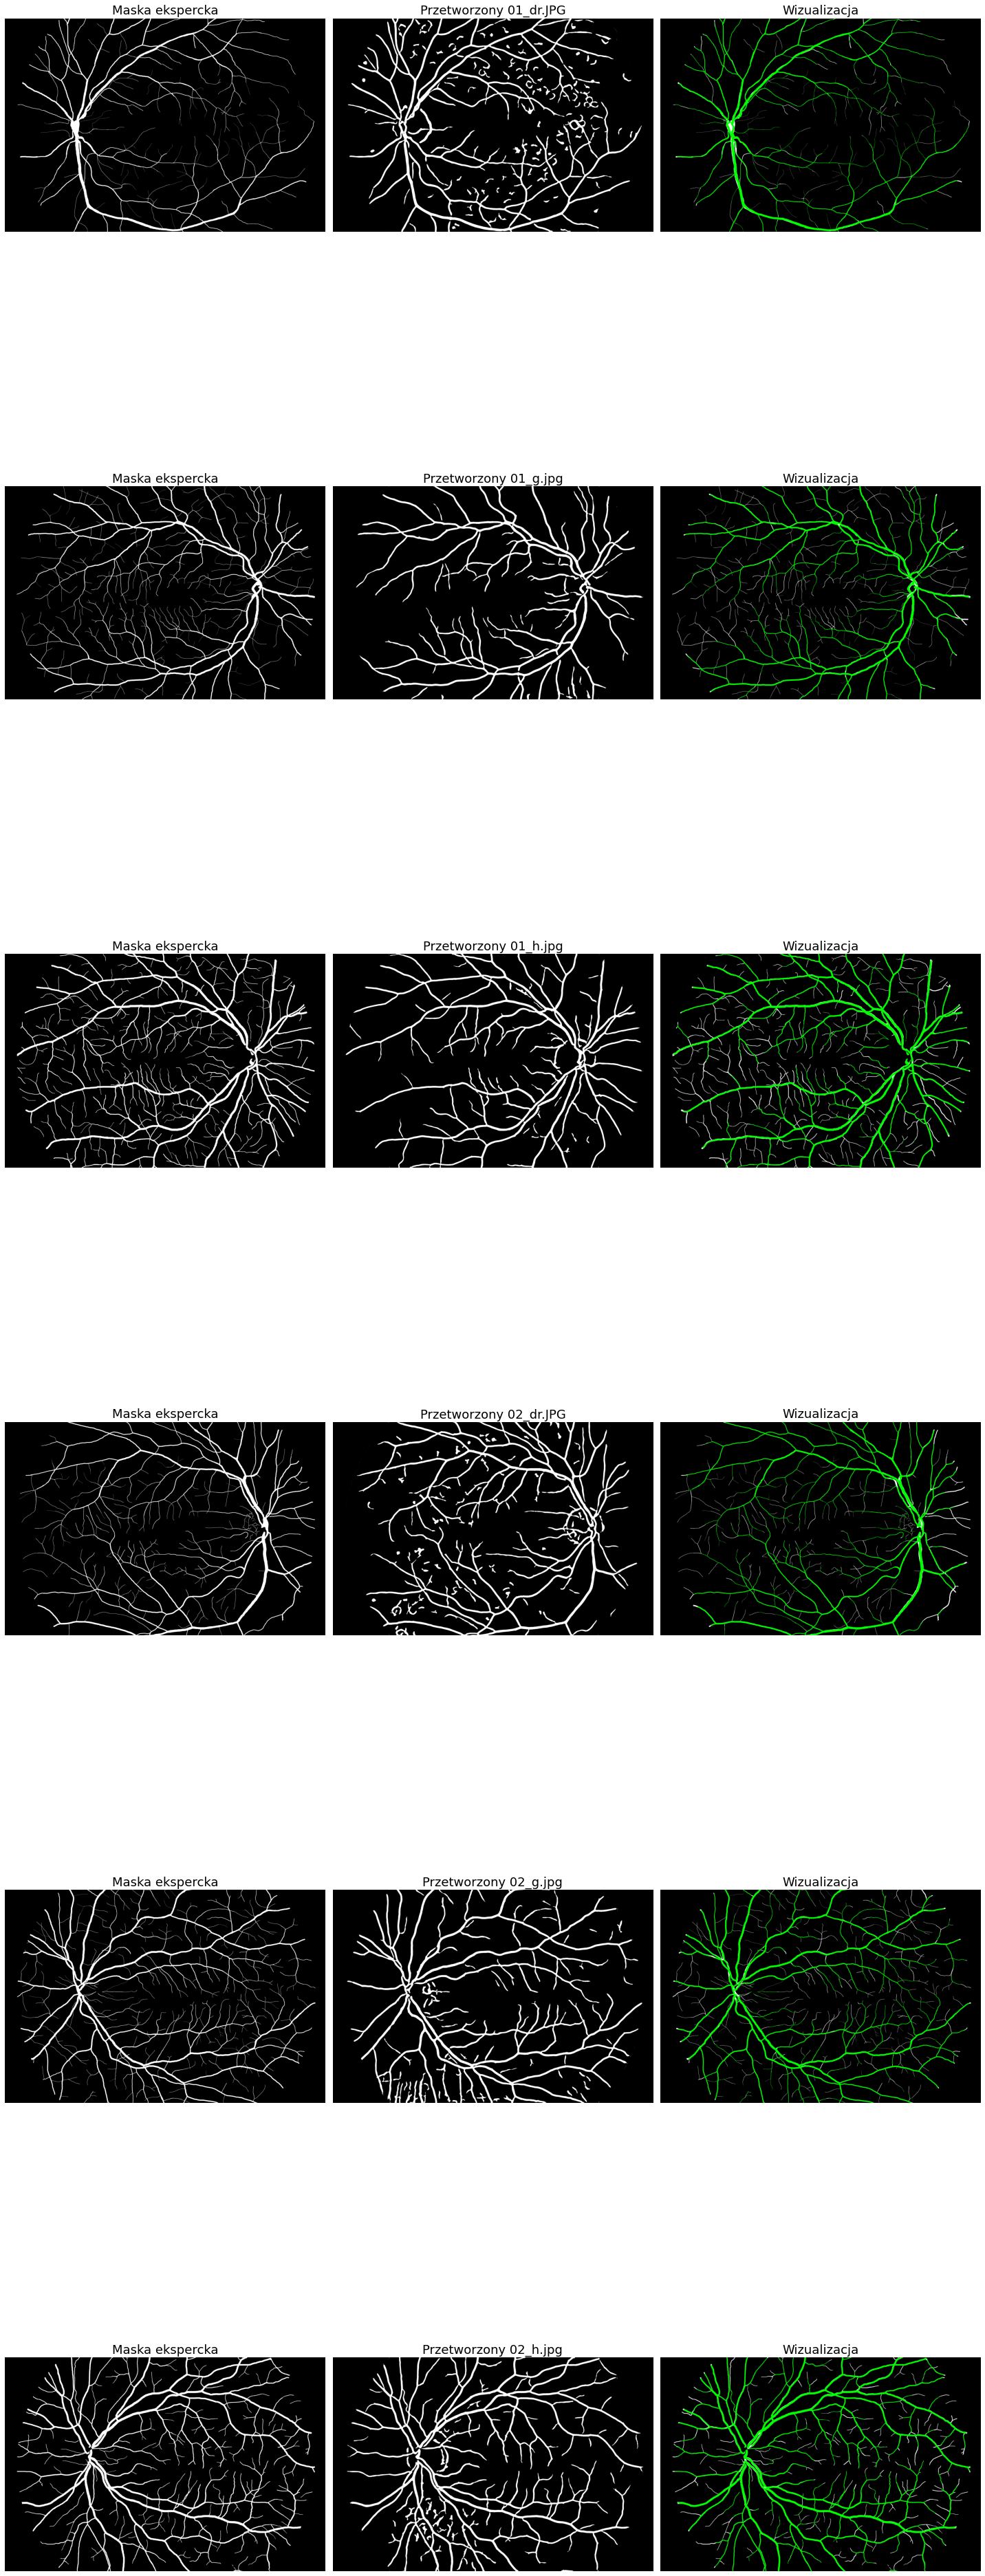

In [109]:
def analyse(dir: str, out_dir: str):
    images = sorted(os.listdir(dir), key=lambda x: x.lower())

    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)
        print(f'"{out_dir}" directory has been created.')

    if len(images) % 2 != 0:
        raise Exception("len(images) != len(ground_trouth)")
    
    # Assumes that we have only .jpg (img) and .tif (truth) images!
    img = images[::2]
    truth = images[1::2]
    examples = [{'name': i, 'img': i, 'truth': t, 'comparison': None, 'visualisation': None} 
                for i,t in zip(img,truth)]

    for example in examples:
        example['img'] = process_input(dir + example['img'])
        example['truth'] = cv.imread(dir + example['truth'], cv.IMREAD_GRAYSCALE)
        example['comparison'] = compare(example['img'], example['truth'])
        example['visualisation'] = visualise(example['img'], example['truth'])
        cv.imwrite(out_dir + example['name'][:-4] + ".jpg", example['img'])
        cv.imwrite(out_dir + example['name'][:-4] + "_w.jpg", example['visualisation'])

    fig, axs = plt.subplots(len(examples), 3, sharex=True, sharey=True)
    fig.set_figwidth(20)
    fig.set_figheight(10 * len(examples))

    # Workaround for 1 image
    axs = np.array([axs]) if len(examples) == 1 else axs
  
    for i, example in enumerate(examples):
        axs[i, 0].set_title('Maska ekspercka', {'fontsize': 18})
        axs[i, 0].axis('off')
        axs[i, 0].imshow(example['truth'], cmap='gray')

        axs[i, 1].set_title('Przetworzony ' + example['name'], {'fontsize': 18})
        axs[i, 1].axis('off')
        axs[i, 1].imshow(example['img'], cmap='gray')
        
        axs[i, 2].set_title('Wizualizacja', {'fontsize': 18})
        axs[i, 2].axis('off')
        axs[i, 2].imshow(example['visualisation'], cmap='gray')
   
        print(f'{example["name"]}: {example["comparison"]}')
    
    plt.tight_layout()
    

analyse('examples/', 'output/')